# This exercise consists of two deliverables:

1) A jupyter notebook containing your code and commentary
* Creation of your context
* Preparation of data (get it into parquet)
* MLlib based analysis
* Visualization of results



2) A pdf containing three slides
* Motivation
* Code snippet and explanation (show off)
* Visualization

In [2]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np

# CREATION OF CONTEXT

In [3]:
# Initialize the spark environment 

conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

# DATA PREP

In [4]:
role = get_execution_role() 
bucket='odl-spark19spds6003-001'
data_key = 'mc9bx/mc9bx.csv'
data_location = 's3://{}/{}'.format(bucket, data_key) #s3:// is the way to call a bucket
pd.read_csv(data_location)                            # to read a bucket you need permission...it's solved here but we might have trouble with permission

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
5,11,0.22489,12.5,7.87,0,0.524,6.377,94.3,6.3467,5,311,15.2,392.52,20.45,15.0
6,12,0.11747,12.5,7.87,0,0.524,6.009,82.9,6.2267,5,311,15.2,396.90,13.27,18.9
7,13,0.09378,12.5,7.87,0,0.524,5.889,39.0,5.4509,5,311,15.2,390.50,15.71,21.7
8,14,0.62976,0.0,8.14,0,0.538,5.949,61.8,4.7075,4,307,21.0,396.90,8.26,20.4
9,15,0.63796,0.0,8.14,0,0.538,6.096,84.5,4.4619,4,307,21.0,380.02,10.26,18.2


In [5]:
df = sqlc.createDataFrame(pd.read_csv(data_location))
df

DataFrame[ID: bigint, crim: double, zn: double, indus: double, chas: bigint, nox: double, rm: double, age: double, dis: double, rad: bigint, tax: bigint, ptratio: double, black: double, lstat: double, medv: double]

In [7]:
#Writing to Parquet
parquetPath = '/home/ec2-user/SageMaker/mc9bx/mc9bx-hw4-pqt' # changed the name
df.write.parquet(parquetPath)


In [8]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3') 
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "sample_data/pqt/"+f)

In [9]:
df = sqlc.read.parquet(parquetPath)
df

DataFrame[ID: bigint, crim: double, zn: double, indus: double, chas: bigint, nox: double, rm: double, age: double, dis: double, rad: bigint, tax: bigint, ptratio: double, black: double, lstat: double, medv: double]

In [10]:
pddf = pd.read_csv(data_location)
pddf

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
5,11,0.22489,12.5,7.87,0,0.524,6.377,94.3,6.3467,5,311,15.2,392.52,20.45,15.0
6,12,0.11747,12.5,7.87,0,0.524,6.009,82.9,6.2267,5,311,15.2,396.90,13.27,18.9
7,13,0.09378,12.5,7.87,0,0.524,5.889,39.0,5.4509,5,311,15.2,390.50,15.71,21.7
8,14,0.62976,0.0,8.14,0,0.538,5.949,61.8,4.7075,4,307,21.0,396.90,8.26,20.4
9,15,0.63796,0.0,8.14,0,0.538,6.096,84.5,4.4619,4,307,21.0,380.02,10.26,18.2


In [13]:
# Checking the data schema
df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: long (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: long (nullable = true)
 |-- tax: long (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [14]:
# Checking the first 5 rows
df.take(5)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.5379999999999999, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0),
 Row(ID=2, crim=0.02731, zn=0.0, indus=7.07, chas=0, nox=0.469, rm=6.421, age=78.9, dis=4.9671, rad=2, tax=242, ptratio=17.8, black=396.9, lstat=9.14, medv=21.6),
 Row(ID=4, crim=0.032369999999999996, zn=0.0, indus=2.18, chas=0, nox=0.45799999999999996, rm=6.997999999999999, age=45.8, dis=6.0622, rad=3, tax=222, ptratio=18.7, black=394.63, lstat=2.94, medv=33.4),
 Row(ID=5, crim=0.06905, zn=0.0, indus=2.18, chas=0, nox=0.45799999999999996, rm=7.147, age=54.2, dis=6.0622, rad=3, tax=222, ptratio=18.7, black=396.9, lstat=5.33, medv=36.2),
 Row(ID=7, crim=0.08829, zn=12.5, indus=7.87, chas=0, nox=0.524, rm=6.0120000000000005, age=66.6, dis=5.5605, rad=5, tax=311, ptratio=15.2, black=395.6, lstat=12.43, medv=22.9)]

In [15]:
# First data exploration and analysis

print("Pearson's r(MEDV,TAX) = {}".format(df.corr("medv", "tax")))
print("Pearson's r(MEDV,NOX) = {}".format(df.corr("medv", "nox")))
print("Pearson's r(MEDV,BLACK) = {}".format(df.corr("medv", "black")))
print("Pearson's r(MEDV,RM) = {}".format(df.corr("medv", "rm")))
print("Pearson's r(MEDV,LSTAT) = {}".format(df.corr("medv", "lstat")))


Pearson's r(MEDV,TAX) = -0.44807769440070433
Pearson's r(MEDV,NOX) = -0.4130541519920783
Pearson's r(MEDV,BLACK) = 0.33665955532155767
Pearson's r(MEDV,RM) = 0.6895980892872152
Pearson's r(MEDV,LSTAT) = -0.7386000348786346


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning:

pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead



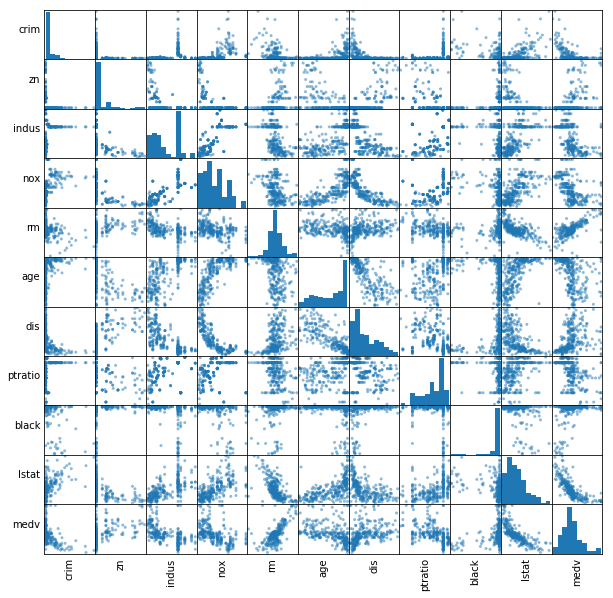

In [16]:
# Correlation analyisis

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
    
# Source/Reference: https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a

# Time for some light ML

In [17]:
# Creating a new dataframe with only the 2 variables I am more interested after checking the correlation analysis above

# medv - median value of owner-occupied homes in \$1000s
# avg number of rooms 
df2 = df.select("medv","rm")
df2.printSchema()

root
 |-- medv: double (nullable = true)
 |-- rm: double (nullable = true)



In [18]:
# create train/test sets

seed = 42 #choose the seed 
(testDF, trainingDF) = df2.randomSplit((0.20, 0.80), seed=seed) # function to split data
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 262, test set N = 71


In [19]:
from pyspark.ml.linalg import Vectors, VectorUDT 

In [20]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("medv", "oneElementVec(rm) as rm") 
testDF = testDF.selectExpr("medv", "oneElementVec(rm) as rm") 


print(testDF.orderBy(testDF.medv.desc()).limit(5)) 

DataFrame[medv: double, rm: vector]


In [21]:
# rename to make ML engine happy

trainingDF = trainingDF.withColumnRenamed("medv", "label").withColumnRenamed("rm", "features") # change variable
testDF = testDF.withColumnRenamed("medv", "label").withColumnRenamed("rm", "features") # change variable

In [22]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()                                                     # call the constractor of Linear regression # we could change LinearRegression for any other method
lrModel = lr.fit(trainingDF)                                               #train our model
type(lrModel)
print("Coefficient: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficient: [8.730576706815834]
Intercept: -31.6555330439087


In [23]:
#take test data frame and make the predictions

predictionsAndLabelsDF = lrModel.transform(testDF) 

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=50.0, features=DenseVector([8.725]), prediction=44.518748723059446), Row(label=50.0, features=DenseVector([7.923]), prediction=37.51682620419314), Row(label=50.0, features=DenseVector([7.929]), prediction=37.56920966443404), Row(label=42.8, features=DenseVector([8.259]), prediction=40.45029997768327), Row(label=37.9, features=DenseVector([7.155]), prediction=30.811743293358592)]


# Evaluation of results obtained

In [24]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print (eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [25]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [26]:
# RMSE

eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

5.744064065857108

In [27]:
# R-squared

eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.5819341803085476